In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from urllib import request
import tarfile
import os
import warnings

In [248]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### Sampling of Data into training and test set

In [249]:
from sklearn.model_selection import train_test_split

In [250]:
X = housing.drop('median_house_value',axis=1) #features
y = housing['median_house_value'] #labels / target

In [251]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [252]:
X_train.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY


In [253]:
y_train.head(3)

14196    291000.0
8267     156100.0
17445    353900.0
Name: median_house_value, dtype: float64

In [254]:
num_features = list(X_train.columns[:-1])
cat_features = ['ocean_proximity']

print('Numerical features: ',*num_features)
print('Categorical features: ',*cat_features)

Numerical features:  longitude latitude housing_median_age total_rooms total_bedrooms population households median_income
Categorical features:  ocean_proximity


In [255]:
X_train_num = X_train[num_features]
X_train_cat = X_train[cat_features]

X_test_num = X_test[num_features]
X_test_cat = X_test[cat_features]

In [256]:
X_train_cat.head(3)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY


In [257]:
corr = X_train_num.corrwith(y_train).sort_values(ascending=False,key=lambda v:abs(v))
corr

median_income         0.687013
latitude             -0.146324
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
longitude            -0.043603
population           -0.025820
dtype: float64

### Pre-pare data for ML model

    missimg values
    all features should be numerical
    data distribution should be normal(less outliers)
    data should be scaled

### Dealing with categorical data

    Encode data into numerical values

        ordinal encoding -> label encoding we assign a numerical number to each category

        nominal encoding -> one hot encoding we create a separate column for each category and for each row we assign to corresponding category columns and rest will be assigned 0

In [258]:
X_train_cat.head()

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY
14265,<1H OCEAN
2271,INLAND


### Transformers

In [259]:
from sklearn.preprocessing import OneHotEncoder

In [260]:
encoder = OneHotEncoder()
encoder.fit(X_train_cat)
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [261]:
# Sparse matrix
X_train_cat_tr = pd.DataFrame(
    encoder.transform(X_train_cat).toarray(),
    columns = [_ for _ in encoder.categories_[0]],
    index = X_train_cat.index )
X_train_cat_tr.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
14196,0.0,0.0,0.0,0.0,1.0
8267,0.0,0.0,0.0,0.0,1.0
17445,0.0,0.0,0.0,1.0,0.0
14265,1.0,0.0,0.0,0.0,0.0
2271,0.0,1.0,0.0,0.0,0.0


In [262]:
# Sparse matrix
X_test_cat_tr = pd.DataFrame(
    encoder.transform(X_test_cat).toarray(),
    columns = [_ for _ in encoder.categories_[0]],
    index = X_test_cat.index )
X_test_cat_tr.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20046,0.0,1.0,0.0,0.0,0.0
3024,1.0,0.0,0.0,0.0,0.0
15663,0.0,0.0,0.0,0.0,1.0
20484,1.0,0.0,0.0,0.0,0.0
9814,1.0,0.0,0.0,0.0,0.0


### Numerical Data Processing

    1.Imputing Missing values
    2.Removal of outliers to make shape data Normal
    3.Scaling as many ML models are sensitive scaling of data

In [263]:
X_train_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [264]:
from sklearn.impute import SimpleImputer

In [265]:
X_train_num.isna().sum().reset_index().T

,0,1,2,3,4,5,6,7
index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0,0,0,0,163,0,0,0


In [266]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train_num)
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [267]:
X_train_num_tr = pd.DataFrame(imputer.transform(X_train_num),
                              columns = X_train_num.columns,
                              index = X_train_num.index)
X_train_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [268]:
X_test_num_tr = pd.DataFrame(imputer.transform(X_test_num),
                              columns = X_test_num.columns,
                              index = X_test_num.index)
X_test_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750


In [269]:
X_train_num_tr.isna().sum().reset_index().T

,0,1,2,3,4,5,6,7
index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0,0,0,0,0,0,0,0


### Outlier Removals

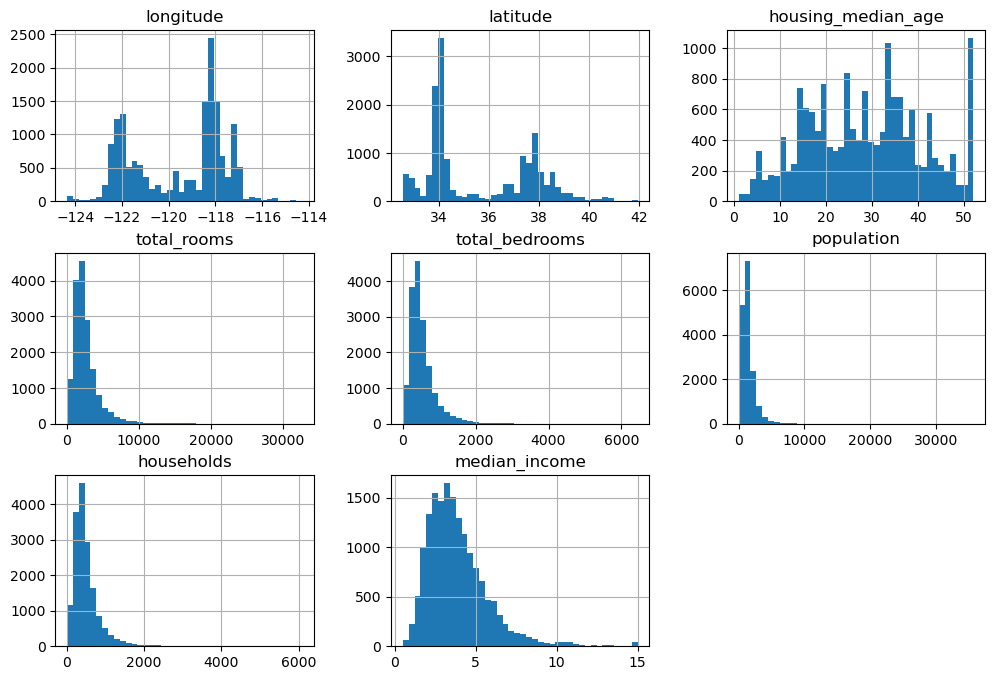

In [270]:
X_train_num_tr.hist(bins=40, figsize=(12,8))
plt.show()

### log

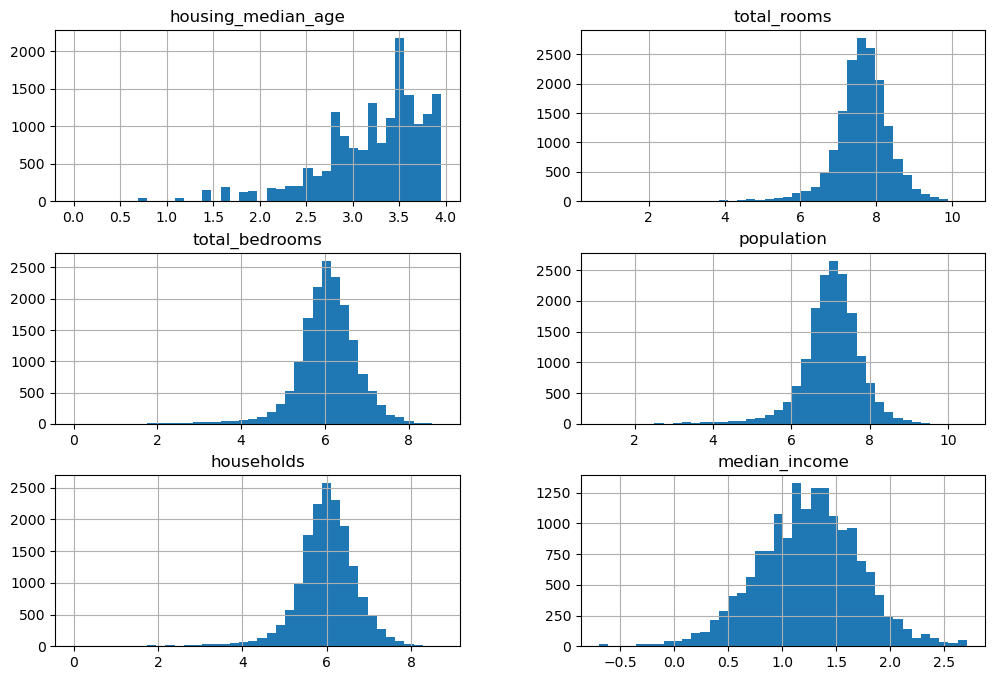

In [271]:
np.log(X_train_num_tr.drop(['latitude','longitude'],axis=1)).hist(bins=40,figsize=(12,8))
plt.show()

### Binning Replace each value with it's percentile

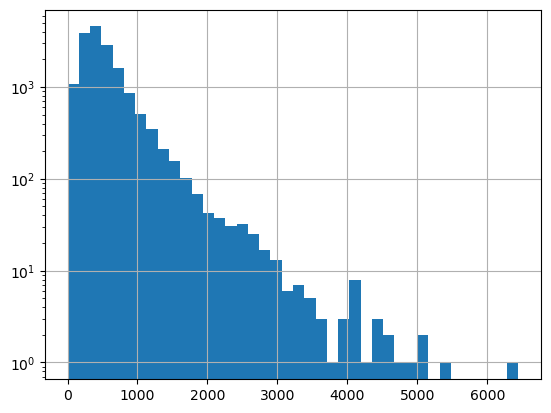

In [272]:
X_train_num_tr['total_bedrooms'].hist(bins=40)
plt.yscale('log')

In [273]:
bins = [0,1000,2000,3000,4000,5000,np.inf]
cat = pd.cut(X_train_num_tr['total_bedrooms'],labels=range(1,len(bins)),bins=bins)
cat

14196    2
8267     1
17445    2
14265    1
2271     1
        ..
11284    1
11964    1
5390     1
860      1
15795    1
Name: total_bedrooms, Length: 16512, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

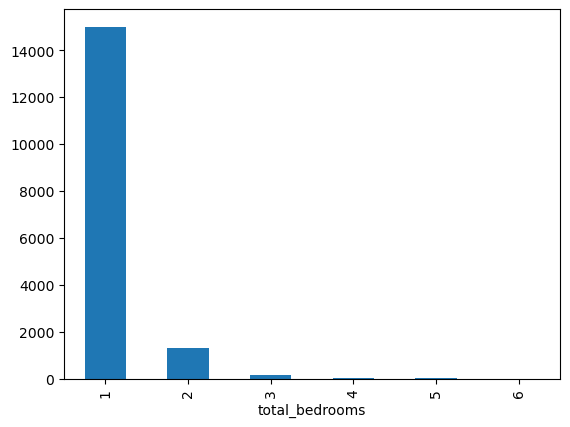

In [274]:
cat.value_counts().plot(kind='bar')
plt.show()

In [275]:
np.percentile(X_train_num_tr['total_bedrooms'],70)
# total number of bedrooms in 70% of data

591.0

In [276]:
bins = [np.percentile(X_train_num_tr['total_bedrooms'],_) for _ in range(1,100)]
bins.insert(0,-np.inf)
bins.append(np.inf)
cat = pd.cut(X_train_num_tr['total_bedrooms'],labels=range(1,len(bins)),bins=bins)
cat

14196    93
8267      7
17445    98
14265    75
2271      2
         ..
11284    14
11964    31
5390     64
860      67
15795    10
Name: total_bedrooms, Length: 16512, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

In [277]:
print(bins)

[-inf, 35.0, 70.22000000000003, 101.0, 122.0, 140.0, 153.65999999999997, 168.0, 180.0, 191.0, 200.0, 209.0, 217.0, 225.0, 233.0, 239.0, 246.0, 253.0, 259.0, 265.0, 271.0, 276.30999999999995, 282.0, 287.0, 292.0, 297.0, 303.0, 309.0, 314.0, 318.0, 325.0, 330.0, 335.0, 341.0, 346.0, 352.0, 357.0, 363.0, 369.0, 374.0, 381.0, 388.0, 393.0, 398.0, 404.0, 410.0, 416.0, 422.0, 428.0, 434.0, 437.0, 440.0, 447.0, 454.0, 460.0, 467.0, 474.0, 481.0, 489.0, 495.0, 502.0, 510.0, 518.0, 526.0, 535.0, 544.0, 552.0, 561.0, 571.0, 580.0, 591.0, 601.0, 611.0, 623.0, 633.0, 645.0, 659.0, 669.0, 686.0, 701.0, 717.8000000000011, 734.0, 750.0, 767.0, 787.0, 809.0, 832.0, 857.0, 887.6800000000003, 924.7900000000009, 962.0, 1007.0, 1053.1200000000008, 1114.0, 1187.0, 1271.0, 1369.0, 1529.0, 1738.5599999999977, 2245.579999999987, inf]


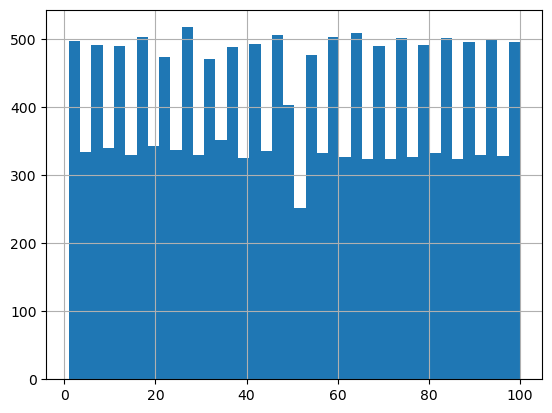

In [278]:
cat.hist(bins=40)
plt.show()

### Scaling

##### 1> Min Max Scaler

* Drawback

  -> presence of outliers decreases efficiency greatley

In [279]:
a = np.array([35,40,100,26,30,45,25,100,1000])

scaled_a = (a - a.min())/(a.max()-a.min())
scaled_a

array([0.01025641, 0.01538462, 0.07692308, 0.00102564, 0.00512821,
       0.02051282, 0.        , 0.07692308, 1.        ])

In [280]:
from sklearn.preprocessing import MinMaxScaler

In [281]:
X_train_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [282]:
scaler = MinMaxScaler()
scaler.fit(X_train_num_tr)
scaler.transform(X_train_num_tr)

array([[0.71015936, 0.02231668, 0.64705882, ..., 0.07430141, 0.17612235,
        0.28192025],
       [0.72908367, 0.01594049, 0.17647059, ..., 0.01947925, 0.02729814,
        0.28723052],
       [0.20717131, 0.55260361, 0.52941176, ..., 0.08327027, 0.24387436,
        0.21983145],
       ...,
       [0.5       , 0.39744952, 0.29411765, ..., 0.03010174, 0.0853478 ,
        0.11207432],
       [0.71314741, 0.16365569, 0.41176471, ..., 0.04383531, 0.08107219,
        0.14852899],
       [0.54681275, 0.17853348, 0.41176471, ..., 0.01877855, 0.03190265,
        0.39798761]])

#### 2> Standard Scaler

-> converts data into standard normal distribution

mean = 0 , std(sigma) = 1

-> generally used scaler

$$ S(x_i) = \frac {x_i - \bar X} { \sigma_X} $$

In [283]:
t = X_train_num_tr['housing_median_age']

In [284]:
t.mean()

28.592720445736433

In [285]:
t.std()

12.618367060318981

<Axes: >

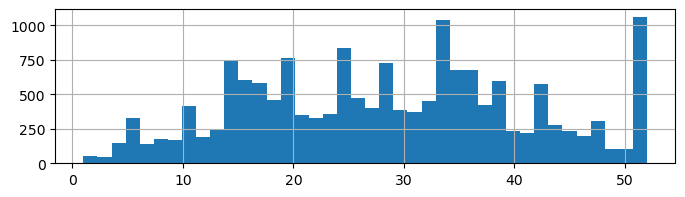

In [286]:
t.hist(bins=40,figsize=(8,2))

In [287]:
t_s = (t-t.mean())/t.std()

<Axes: >

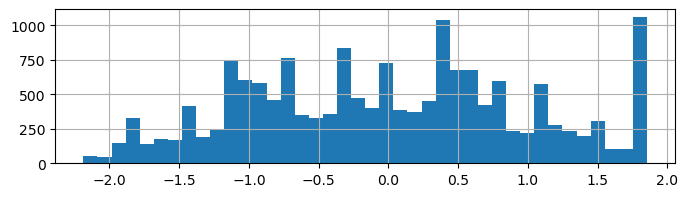

In [288]:
t_s.hist(bins=40,figsize=(8,2))

In [289]:
from sklearn.preprocessing import StandardScaler

In [290]:
scaler = StandardScaler()

In [291]:
scaler.fit(X_train_num_tr)

StandardScaler()

In [292]:
X_train_num_tr = scaler.transform(X_train_num_tr)

X_train_num_tr = pd.DataFrame(X_train_num_tr,
                              columns=X_train_num.columns,
                              index = X_train_num.index)
X_train_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,1.172993,-1.350415,0.428537,1.570557,1.376799,1.081011,1.507507,0.379698
8267,1.268028,-1.378536,-1.473509,-0.809439,-0.900718,-0.643842,-0.878707,0.420068
17445,-1.352939,0.988349,-0.046974,1.994289,2.441082,1.363196,2.593828,-0.092320
14265,-1.127856,0.758691,-0.284730,0.646558,0.230833,0.661262,0.394820,0.682999
2271,1.793222,-1.083261,-1.632013,-1.117906,-1.181804,-1.203802,-1.255755,-1.255560


In [293]:
X_train_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [294]:
scaler.mean_
#mean hr column ka

array([-119.56512052,   35.63125242,   28.59272045, 2635.51592781,
        537.91727229, 1428.12312258,  500.25999273,    3.8635854 ])

In [295]:
scaler.var_
#variance hr column ka

array([3.99704902e+00, 4.55227192e+00, 1.59213544e+02, 4.59185225e+06,
       1.73258053e+05, 1.28597759e+06, 1.43839529e+05, 3.63796069e+00])

In [296]:
X_test_num_tr = scaler.transform(X_test_num_tr)
X_test_num_tr = pd.DataFrame(X_test_num_tr, columns=X_test_num.columns,
                             index=X_test_num.index)
X_test_num_tr.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20046,-1.407959,2.361612,-1.473509,-0.165440,-0.225631,-0.135910,-0.164161,-0.865909
3024,0.597781,-0.844229,0.507789,-0.666640,-0.795010,-0.729379,-0.757419,0.454671
15663,1.162989,-1.364476,0.824797,0.211626,-0.256863,-0.223211,-0.179981,1.955030


### Custom Transformers

In [297]:
from sklearn.preprocessing import FunctionTransformer

In [298]:
def mytransformation_func(X):
    # .....
    # spaces remove from column
    # replacing NA values with 0
    # log , exp , math function R = VI/A
    return X_tr

X -> log(x) #Transform

exp(log(x)) -> X #Reverse Transform

In [299]:
log_tr = FunctionTransformer(np.log,np.exp)

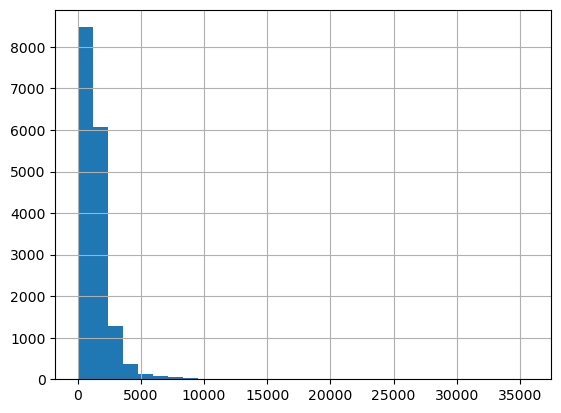

In [300]:
X_train_num["population"].hist(bins=30)
plt.show()

In [301]:
pop_log = log_tr.transform(X_train_num["population"])

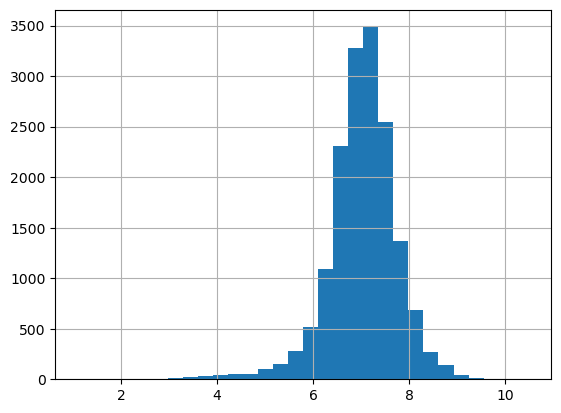

In [302]:
pop_log.hist(bins=30)
plt.show()

### Custom Transformer

fit -> learn required parameters from training data

transform -> convert input values to desired output values after applying tranformation

In [303]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.utils.validation import check_array,check_is_fitted

$$S_(X_i) = \frac {x_i - min(X)} {max(X) - min(X)}$$

In [304]:
class MyMinMaxScaler(BaseEstimator,TransformerMixin):
    def fit(self,X_train,y_train=None):
        # learning min,max
        X_train = np.array(X_train)
        self.min_ = X_train.min(axis=0) #axis=0 column wise
        self.max_ = X_train.max(axis=0)
        self.n_features_in_ = X_train.shape[1]
        return self
    def transform(self,X,y=None):
        check_is_fitted(self) #does your object self contains param_ attributes
        assert self.n_features_in == X.shape[1]
        X = check_array(X)
        return (X-self.min_) / (self.max_ - self.min_)

In [305]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
mimx = MyMinMaxScaler()
mimx.fit(X_train_num.dropna())
sc.fit(X_train_num.dropna())

MinMaxScaler()

In [306]:
sc.data_min_

array([-124.35  ,   32.54  ,    1.    ,    2.    ,    1.    ,    3.    ,
          1.    ,    0.4999])

In [307]:
mimx.min_

array([-124.35  ,   32.54  ,    1.    ,    2.    ,    1.    ,    3.    ,
          1.    ,    0.4999])

In [308]:
sc.data_max_

array([-1.14310e+02,  4.19500e+01,  5.20000e+01,  3.26270e+04,
        6.44500e+03,  3.56820e+04,  6.08200e+03,  1.50001e+01])

In [309]:
mimx.max_

array([-1.14310e+02,  4.19500e+01,  5.20000e+01,  3.26270e+04,
        6.44500e+03,  3.56820e+04,  6.08200e+03,  1.50001e+01])

In [310]:
tr = mimx.transform(X_train_num.dropna())
trr = sc.transform(X_train_num.dropna())

AttributeError: 'MyMinMaxScaler' object has no attribute 'n_features_in'

In [311]:
X_train_num.dropna().to_numpy()[:5]

array([[-1.1722e+02,  3.2750e+01,  3.4000e+01,  6.0010e+03,  1.1110e+03,
         2.6540e+03,  1.0720e+03,  4.5878e+00],
       [-1.1703e+02,  3.2690e+01,  1.0000e+01,  9.0100e+02,  1.6300e+02,
         6.9800e+02,  1.6700e+02,  4.6648e+00],
       [-1.2227e+02,  3.7740e+01,  2.8000e+01,  6.9090e+03,  1.5540e+03,
         2.9740e+03,  1.4840e+03,  3.6875e+00],
       [-1.2182e+02,  3.7250e+01,  2.5000e+01,  4.0210e+03,  6.3400e+02,
         2.1780e+03,  6.5000e+02,  5.1663e+00],
       [-1.1598e+02,  3.3320e+01,  8.0000e+00,  2.4000e+02,  4.6000e+01,
         6.3000e+01,  2.4000e+01,  1.4688e+00]])

### Feature Engineering

    Feature Selection - We select important feature further and drop irrelvant features

    Feature Extraction - We create new features based on existing features or we collect new feature regarding same instances 


In [312]:
new_housing = housing.copy()
new_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [313]:
new_housing["rooms_per_household"] = new_housing["total_bedrooms"]/new_housing["households"]

In [314]:
new_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1.023810
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.971880
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1.073446
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,1.073059
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1.081081


In [315]:
new_housing['rooms_per_household'].describe()

count    20433.000000
mean         1.097062
std          0.476104
min          0.333333
25%          1.006029
50%          1.048889
75%          1.099631
max         34.066667
Name: rooms_per_household, dtype: float64

In [316]:
new_housing.groupby('rooms_per_household')['median_house_value'].mean()

rooms_per_household
0.333333     275000.000000
0.375000     250000.000000
0.444444      80000.000000
0.500000     295833.666667
0.526316     250000.000000
                 ...      
11.410714    221400.000000
14.111111     87500.000000
15.312500     67500.000000
25.636364    500001.000000
34.066667    162500.000000
Name: median_house_value, Length: 14121, dtype: float64

In [317]:
new_housing['rooms_per_household_cat'] = pd.cut(new_housing['rooms_per_household'],
                                            bins = [0,10,20,30,40,50,60,70,np.inf],
                                            labels = ["10","20","30","40","50","60","70",'>80'])

In [318]:
new_housing.groupby('rooms_per_household_cat')['median_house_value'].mean().sort_values(ascending=False)

rooms_per_household_cat
30     500001.000000
10     206863.266402
20     174671.428571
40     162500.000000
50               NaN
60               NaN
70               NaN
>80              NaN
Name: median_house_value, dtype: float64

(0.0, 70.0)

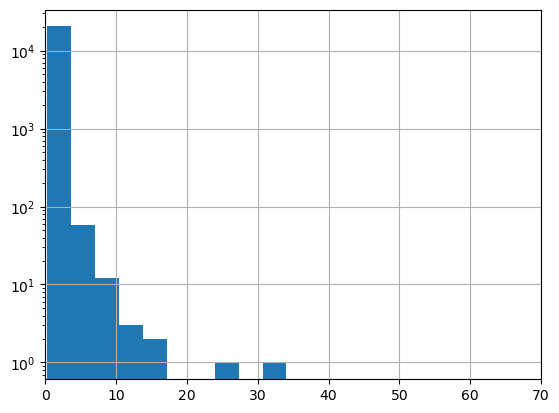

In [319]:
new_housing.rooms_per_household.hist()
plt.yscale('log')
plt.xlim([0, 70])

In [320]:
new_housing.corrwith(new_housing['median_house_value'],numeric_only=True).sort_values(ascending=False,
                                                                                      key = lambda x: abs(x))

median_house_value     1.000000
median_income          0.688075
latitude              -0.144160
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
rooms_per_household   -0.046739
longitude             -0.045967
population            -0.024650
dtype: float64

## Data pipelines

        It combines all transformations steps together in single block so it becomes easy to maintain and update the code

In [321]:
from sklearn.preprocessing import StandardScaler  #scaling
from sklearn.impute import SimpleImputer  #missing values
from sklearn.preprocessing import FunctionTransformer #for log
from sklearn.pipeline import Pipeline, make_pipeline
import numpy as np
import pandas as pd 

In [322]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    # FunctionTransformer(np.log),
    StandardScaler()
)

In [323]:
X_train_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [324]:
X_train_num_tr = num_pipeline.fit_transform(X_train_num)
X_train_num_tr = pd.DataFrame(X_train_num_tr, columns = X_train_num.columns, index= X_train_num.index)
X_train_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,1.172993,-1.350415,0.428537,1.570557,1.376799,1.081011,1.507507,0.379698
8267,1.268028,-1.378536,-1.473509,-0.809439,-0.900718,-0.643842,-0.878707,0.420068
17445,-1.352939,0.988349,-0.046974,1.994289,2.441082,1.363196,2.593828,-0.092320
14265,-1.127856,0.758691,-0.284730,0.646558,0.230833,0.661262,0.394820,0.682999
2271,1.793222,-1.083261,-1.632013,-1.117906,-1.181804,-1.203802,-1.255755,-1.255560


In [325]:
X_train_num_tr = num_pipeline.fit_transform(X_train_num)

In [326]:
X_train_num_tr

array([[ 1.17299302, -1.35041487,  0.42853749, ...,  1.0810111 ,
         1.50750741,  0.37969797],
       [ 1.26802809, -1.37853628, -1.47350948, ..., -0.64384214,
        -0.87870693,  0.42006824],
       [-1.3529389 ,  0.98834939, -0.04697426, ...,  1.36319568,
         2.5938282 , -0.09231969],
       ...,
       [ 0.11760365,  0.30406165, -0.99799774, ..., -0.30962978,
         0.0520485 , -0.91152173],
       [ 1.18799856, -0.72705686, -0.522486  , ...,  0.12246535,
        -0.01650573, -0.63438241],
       [ 0.35269038, -0.66144022, -0.522486  , ..., -0.66588782,
        -0.80487931,  1.26207687]])

In [327]:
from sklearn.preprocessing import StandardScaler  #scaling
from sklearn.impute import SimpleImputer  #missing values
from sklearn.preprocessing import FunctionTransformer #for log
from sklearn.pipeline import Pipeline, make_pipeline

In [328]:
num_pipeline = Pipeline([ # created a list Pipeline
    ("missing value imputer", SimpleImputer(strategy="median") ), #passing tuples
    ("scaling", StandardScaler() )
])

In [329]:
num_pipeline.fit(X_train_num)

Pipeline(steps=[('missing value imputer', SimpleImputer(strategy='median')),
                ('scaling', StandardScaler())])

In [330]:
num_pipeline.feature_names_in_
# feature names input

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [331]:
num_pipeline.get_feature_names_out()
# feature names output

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [332]:
num_pipeline.get_params()

{'memory': None,
 'steps': [('missing value imputer', SimpleImputer(strategy='median')),
  ('scaling', StandardScaler())],
 'verbose': False,
 'missing value imputer': SimpleImputer(strategy='median'),
 'scaling': StandardScaler(),
 'missing value imputer__add_indicator': False,
 'missing value imputer__copy': True,
 'missing value imputer__fill_value': None,
 'missing value imputer__keep_empty_features': False,
 'missing value imputer__missing_values': nan,
 'missing value imputer__strategy': 'median',
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True}

In [333]:
num_pipeline.named_steps

{'missing value imputer': SimpleImputer(strategy='median'),
 'scaling': StandardScaler()}

In [334]:
(num_pipeline.named_steps["missing value imputer"])

SimpleImputer(strategy='median')

In [335]:
(num_pipeline.named_steps["missing value imputer"]).statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

## Column Transformer Pipeline

In [336]:
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [337]:
print(num_features)
print(cat_features)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']


In [338]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    # (strategy = 'most_frequent') -> is a hyperparameter
    # parameters -> parameters of model , model learns those parameters
    #               when we call fit function on training data
    # hyperparameters -> do not depend on training data
    # (strategy = 'most_frequent') -> har column ka mod(most-frequent) nikalega aur usko store karega
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)
    # (step_name, Transformer/Pipeline, feature name)
])

In [339]:
X_train_tr = preprocessing_pipeline.fit_transform(X_train)

In [340]:
X_train_tr[:5]

array([[ 1.17299302, -1.35041487,  0.42853749,  1.57055658,  1.3767992 ,
         1.0810111 ,  1.50750741,  0.37969797,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 1.26802809, -1.37853628, -1.47350948, -0.8094394 , -0.90071778,
        -0.64384214, -0.87870693,  0.42006824,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [-1.3529389 ,  0.98834939, -0.04697426,  1.9942892 ,  2.44108192,
         1.36319568,  2.5938282 , -0.09231969,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [-1.12785585,  0.75869118, -0.28473013,  0.64655814,  0.23083338,
         0.66126154,  0.39481962,  0.68299933,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.79322185, -1.08326143, -1.63201339, -1.11790554, -1.18180373,
        -1.20380217, -1.25575517, -1.25556038,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]])

In [341]:
cols = [value.split("__")[1] for value in preprocessing_pipeline.get_feature_names_out()]
X_train_tr = pd.DataFrame(X_train_tr, columns = cols, index = X_train.index)

In [342]:
X_train_tr.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,1.172993,-1.350415,0.428537,1.570557,1.376799,1.081011,1.507507,0.379698,0.0,0.0,0.0,0.0,1.0
8267,1.268028,-1.378536,-1.473509,-0.809439,-0.900718,-0.643842,-0.878707,0.420068,0.0,0.0,0.0,0.0,1.0
17445,-1.352939,0.988349,-0.046974,1.994289,2.441082,1.363196,2.593828,-0.092320,0.0,0.0,0.0,1.0,0.0
14265,-1.127856,0.758691,-0.284730,0.646558,0.230833,0.661262,0.394820,0.682999,1.0,0.0,0.0,0.0,0.0


In [343]:
X_train_tr.isna().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12
index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [344]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

pipeline = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object)) #pd.CategoricalDtype
)

In [345]:
X_train.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [346]:
X_train_tr = pipeline.fit_transform(X_train)

In [347]:
X_train_tr[0]

array([ 1.17299302, -1.35041487,  0.42853749,  1.57055658,  1.3767992 ,
        1.0810111 ,  1.50750741,  0.37969797,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ])

In [348]:
pipeline.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [349]:
fnames = pipeline.get_feature_names_out()
cols = [name.split("__")[1] for name in fnames]
cols = [(name.split("_")[2] if "ocean" in name else name) for name in cols]
cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [350]:
X_train_tr = pd.DataFrame(X_train_tr, columns = cols, index = X_train.index)

In [351]:
X_train_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
14196,1.172993,-1.350415,0.428537,1.570557,1.376799,1.081011,1.507507,0.379698,0.0,0.0,0.0,0.0,1.0
8267,1.268028,-1.378536,-1.473509,-0.809439,-0.900718,-0.643842,-0.878707,0.420068,0.0,0.0,0.0,0.0,1.0
17445,-1.352939,0.988349,-0.046974,1.994289,2.441082,1.363196,2.593828,-0.092320,0.0,0.0,0.0,1.0,0.0
14265,-1.127856,0.758691,-0.284730,0.646558,0.230833,0.661262,0.394820,0.682999,1.0,0.0,0.0,0.0,0.0
2271,1.793222,-1.083261,-1.632013,-1.117906,-1.181804,-1.203802,-1.255755,-1.255560,0.0,1.0,0.0,0.0,0.0


### Model Selection and Training

In [352]:
from sklearn.linear_model import LinearRegression

In [353]:
model = LinearRegression()

model.fit(X_train_tr, y_train) #learning

LinearRegression()

In [354]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY


In [355]:
warnings.filterwarnings("ignore")

In [356]:
y_pred = model.predict(pipeline.transform(X_test))

In [357]:
y_pred

array([ 40760.37690828, 264870.25618902, 384166.49995454, ...,
       184272.07214791, 385388.99318014, 244963.73676864])

In [358]:
y_test.to_numpy()

array([ 65600., 353400., 466700., ...,  79400., 490800., 279400.])

### Error Metric

$$\text {Mean Squared Error MSE} = \frac {{\sum (\hat y_i - y_i )}^2} {N}$$

In [359]:
error = (y_test - y_pred)
error

20046     24839.623092
3024      88529.743811
15663     82533.500045
20484    200443.660875
9814      37227.761118
             ...      
15362     37993.901092
16623    -16400.437655
18086   -104872.072148
2144     105411.006820
3665      34436.263231
Name: median_house_value, Length: 4128, dtype: float64

In [360]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))

MSE: 4870819254.394043
RMSE: 69791.2548561354


In [361]:
y_test.mean()

209834.47262596898

In [362]:
(69791/209834)*100

33.260100841617664

In [363]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [364]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing.drop('median_house_value', axis=1), 
                                                    housing['median_house_value'], test_size=0.2)

In [365]:
def get_rooms_per_household(X, y=None):
    return (X[:, 0]/X[:, 1]).reshape(-1,1)

In [366]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

new_feature_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(get_rooms_per_household),
    StandardScaler() )

pipeline = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object)), #pd.CategoricalDtype
    (new_feature_pipeline, ['total_rooms', 'households'])
)

In [367]:
pipeline.fit_transform(X_train)

array([[-1.18032363,  0.80714486,  0.58260797, ...,  0.        ,
         0.        , -0.28825529],
       [-0.52702316,  0.80714486, -0.68724679, ...,  0.        ,
         0.        , -0.48690708],
       [ 0.51526536, -0.69661876, -0.05231941, ...,  0.        ,
         0.        ,  1.0381468 ],
       ...,
       [ 0.64991507, -0.73409574,  0.90007166, ...,  0.        ,
         0.        , -1.19820761],
       [-0.84619286,  1.10696066, -0.13168533, ...,  0.        ,
         0.        , -0.26596023],
       [ 0.40555077, -0.63571868, -0.21105125, ...,  0.        ,
         0.        , -0.15028486]])